In [11]:
print(np_data[:200,:])
print(np_data[:200,[0,1,3,5,6,7,10,11,12,13,14,17,18,19,22,23,24]].shape)
np_data[:200,[5,7,10,14,17,19,22,24]])
np_data[:200,[4,10,17]])

[[36.9  21.8   1.7  ...  2.    0.32  2.4 ]
 [36.1  12.9   2.8  ...  2.    0.32  1.8 ]
 [25.3  13.7   1.8  ...  2.    0.32  1.3 ]
 ...
 [20.7  14.5   1.4  ...  4.    2.89  3.9 ]
 [35.2  12.7   2.8  ...  4.    2.89  3.8 ]
 [42.1  17.    2.5  ...  4.    2.89  4.4 ]]
(200, 17)


In [1]:
import sys
sys.path.append("/root/autodl-tmp/pykan-master")
from kan import *
import torch
from kan import KAN, create_dataset
import pandas as pd
import numpy as np

# Device setup: Use GPU if available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create the KAN model and move it to the GPU
model = KAN(width=[21, 20, 10, 1], grid=10, k=3, seed=1).to(device)

# Define a sample function and create a dataset (for demonstration)
f = lambda x: torch.exp((torch.sin(torch.pi * (x[:, [0]]**2 + x[:, [1]]**2)) + torch.sin(torch.pi * (x[:, [2]]**2 + x[:, [3]]**2))) / 2)
dataset = create_dataset(f, n_var=4, train_num=3000, device=device)

# Load and process the CSV data
df = pd.read_csv('dynamic_supply_chain_logistics_dataset.csv')

# Process timestamp: Convert to Unix timestamp (seconds since 1970)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df['timestamp'] = df['timestamp'].apply(lambda x: x.timestamp()).astype('float64')

# Process risk_classification: Map categories to numerical values
risk_map = {'Low Risk': 0.0, 'Moderate Risk': 0.5, 'High Risk': 1.0}
df['risk_classification'] = df['risk_classification'].map(risk_map).astype('float64')

# Convert DataFrame to NumPy array with float32 type
structured_array = df.to_numpy().astype(np.float32)

# Standardization function: Normalize along dimension 0
def normalize_along_dim0(tensor):
    mean = tensor.mean(dim=0)
    std = tensor.std(dim=0, unbiased=True)
    normalized_tensor = (tensor - mean) / (std + 1e-8)  # Add small constant to avoid division by zero
    return normalized_tensor

# Split data into train and test sets and move to GPU
train_input = torch.from_numpy(structured_array[:10000, 1:-4]).float().to(device)
test_input = torch.from_numpy(structured_array[29000:, 1:-4]).float().to(device)

train_label = torch.from_numpy(structured_array[:10000, -1:]).float().to(device)
test_label = torch.from_numpy(structured_array[29000:, -1:]).float().to(device)

# col_to_remove = 2
# train_input = torch.cat((train_input[:, :col_to_remove], train_input[:, col_to_remove + 1:]), dim=1)
# test_input = torch.cat((test_input[:, :col_to_remove], test_input[:, col_to_remove + 1:]), dim=1)
# train_label = torch.from_numpy(structured_array[:10000, 2+1:2+2]).float().to(device)
# test_label = torch.from_numpy(structured_array[29000:, 2+1:2+2]).float().to(device)

# Normalize the data
train_input = normalize_along_dim0(train_input)
test_input = normalize_along_dim0(test_input)
train_label = normalize_along_dim0(train_label)
test_label = normalize_along_dim0(test_label)

# Update dataset with processed data
dataset['train_input'] = train_input
dataset['test_input'] = test_input
dataset['train_label'] = train_label
dataset['test_label'] = test_label

# Print shapes to verify
print(dataset['train_input'].shape, dataset['test_input'].shape, dataset['train_label'].shape, dataset['test_label'].shape)

# Train the model on GPU
model.fit(dataset, opt="LBFGS", steps=100)

Using device: cuda
checkpoint directory created: ./model
saving model version 0.0
torch.Size([10000, 21]) torch.Size([3065, 21]) torch.Size([10000, 1]) torch.Size([3065, 1])


| train_loss: 1.84e-01 | test_loss: 1.91e+00 | reg: 9.77e+01 | : 100%|█| 100/100 [00:46<00:00,  2.13

saving model version 0.1


{'train_loss': [array(0.8906426, dtype=float32),
  array(0.74266016, dtype=float32),
  array(0.6338348, dtype=float32),
  array(0.56393516, dtype=float32),
  array(0.50825644, dtype=float32),
  array(0.5129818, dtype=float32),
  array(0.4697494, dtype=float32),
  array(0.4375008, dtype=float32),
  array(0.4088765, dtype=float32),
  array(0.3857929, dtype=float32),
  array(0.4017929, dtype=float32),
  array(0.37456173, dtype=float32),
  array(0.35702848, dtype=float32),
  array(0.3435141, dtype=float32),
  array(0.33151564, dtype=float32),
  array(0.3567167, dtype=float32),
  array(0.33886242, dtype=float32),
  array(0.32717913, dtype=float32),
  array(0.3175523, dtype=float32),
  array(0.30911428, dtype=float32),
  array(0.33493885, dtype=float32),
  array(0.32061753, dtype=float32),
  array(0.3136404, dtype=float32),
  array(0.30748677, dtype=float32),
  array(0.29987, dtype=float32),
  array(0.31424162, dtype=float32),
  array(0.30191737, dtype=float32),
  array(0.29593715, dtype=flo

In [2]:
model = model.prune(edge_th=1e-2)
model = model.refine(20)
# model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=2.);
model.fit(dataset, opt="LBFGS", steps=100);

saving model version 0.2
saving model version 0.3


| train_loss: 4.59e-04 | test_loss: 1.83e+00 | reg: 9.78e+01 | : 100%|█| 100/100 [00:46<00:00,  2.14

saving model version 0.4


In [3]:

model = model.prune(edge_th=1e-2)
model = model.refine(30)
# model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=2.);
model.fit(dataset, opt="LBFGS", steps=100);

saving model version 0.5
saving model version 0.6


| train_loss: 1.38e-05 | test_loss: 1.79e+00 | reg: 9.78e+01 | : 100%|█| 100/100 [00:41<00:00,  2.39


saving model version 0.7


In [8]:
model = model.prune(edge_th=5e-2)
model = model.refine(50)
# model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=2.);
model.fit(dataset, opt="LBFGS", steps=100);

saving model version 0.8
saving model version 0.9


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [03:03<00:00,  1.83s/it]

saving model version 0.10


In [4]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.68744295835495, c=1
fixing (0,0,1) with x, r2=0.6878251433372498, c=1
fixing (0,0,2) with x, r2=0.5745012760162354, c=1
fixing (0,0,3) with x, r2=0.34868350625038147, c=1
fixing (0,0,4) with x, r2=0.4075958728790283, c=1
fixing (0,0,5) with x, r2=0.6205072402954102, c=1
fixing (0,0,6) with x, r2=0.8793882131576538, c=1
fixing (0,0,7) with exp, r2=0.9732034802436829, c=2
fixing (0,0,8) with x, r2=0.6420887112617493, c=1
fixing (0,0,9) with x, r2=0.9368529319763184, c=1
fixing (0,0,10) with sin, r2=0.9977093935012817, c=2
fixing (0,0,11) with x, r2=0.5623968243598938, c=1
fixing (0,0,12) with x, r2=0.19207186996936798, c=1
fixing (0,0,13) with x, r2=0.0681590735912323, c=1
fixing (0,0,14) with x, r2=0.8074703216552734, c=1
fixing (0,0,15) with x, r2=0.5853304266929626, c=1
fixing (0,0,16) with x, r2=0.5973613858222961, c=1
fixing (0,0,17) with x, r2=0.537246584892273, c=1
fixing (0,0,18) with x, r2=0.7247173190116882, c=1
fixing (0,0,19) with x, r2=0.177650734

0.0255*x_1 - 0.012*x_10 + 0.0061*x_11 + 0.0058*x_12 + 0.0051*x_13 + 0.0096*x_14 + 0.0022*x_15 + 0.0131*x_16 - 0.0013*x_17 + 0.007*x_18 - 0.0065*x_19 + 0.0046*x_2 - 0.0093*x_20 - 0.0095*x_21 - 0.0065*x_3 + 0.0023*x_4 - 0.0061*x_5 + 0.0005*x_6 - 0.0072*x_7 + 0.0087*x_8 - 0.0024*x_9 - 0.0009*exp(1.4985*x_2) - 0.0045*sin(0.7569*x_1 + 1.9695) + 0.0172*sin(0.5002*x_10 + 5.0729) - 0.0101*sin(0.8886*x_17 + 8.4074) + 0.0445

In [ ]:

model.plot()

KeyboardInterrupt: 

In [5]:
model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.00e+00 | test_loss: 1.00e+00 | reg: 0.00e+00 | : 100%|█| 100/100 [02:14<00:00,  1.34

saving model version 0.9


In [6]:
formula = model.symbolic_formula()[0][0]
print(ex_round(formula, 6))
ex_round(formula, 6)

0.025496*x_1 - 0.01202*x_10 + 0.006061*x_11 + 0.005805*x_12 + 0.005098*x_13 + 0.009572*x_14 + 0.002228*x_15 + 0.013142*x_16 - 0.001313*x_17 + 0.007047*x_18 - 0.006511*x_19 + 0.004641*x_2 - 0.009349*x_20 - 0.009514*x_21 - 0.006465*x_3 + 0.002263*x_4 - 0.006106*x_5 + 0.000488*x_6 - 0.007249*x_7 + 0.008696*x_8 - 0.002392*x_9 - 0.000865*exp(1.49848*x_2) - 0.004506*sin(0.75688*x_1 + 1.96952) + 0.017151*sin(0.50016*x_10 + 5.07288) - 0.010108*sin(0.88856*x_17 + 8.40744) + 0.044522


0.025496*x_1 - 0.01202*x_10 + 0.006061*x_11 + 0.005805*x_12 + 0.005098*x_13 + 0.009572*x_14 + 0.002228*x_15 + 0.013142*x_16 - 0.001313*x_17 + 0.007047*x_18 - 0.006511*x_19 + 0.004641*x_2 - 0.009349*x_20 - 0.009514*x_21 - 0.006465*x_3 + 0.002263*x_4 - 0.006106*x_5 + 0.000488*x_6 - 0.007249*x_7 + 0.008696*x_8 - 0.002392*x_9 - 0.000865*exp(1.49848*x_2) - 0.004506*sin(0.75688*x_1 + 1.96952) + 0.017151*sin(0.50016*x_10 + 5.07288) - 0.010108*sin(0.88856*x_17 + 8.40744) + 0.044522

In [ ]:
0.0065185404*x_1 - 0.0015733551*x_2 + 0.0023067647*x_3 - 0.0002042616*x_5 + 0.0093320001*x_6 - 0.0015581805*x_7 + 0.0099164573*x_8 + 0.001312092*(0.7166879818 - x_4)**2 + 0.0022884607*(0.7406031193 - x_4)**2 + 0.0009999082*(-0.819869655*x_4 - 1)**2 + 46.6913477541*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2272191467 - exp(-0.2109505087*x_4))**2 + 0.5937337504*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2272989253 - exp(-0.2109505087*x_4))**2 - 47.6681848878*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2281913227 - exp(-0.2109505087*x_4))**2 + 0.4300457254*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2307012479 - exp(-0.2109505087*x_4))**2 + 0.0285281814*exp(0.670906961*x_4) + 0.0060065173 - 2.12668e-5*exp(-2.2581598759*x_4) - 0.1950089176*exp(-0.2109505087*x_4)

In [8]:
ex_round(model, 3)

model_output = model(dataset['train_input'])
print(model_output.shape)
print('kan  MSE:', torch.mean((model_output - dataset['train_label'])**2))
print('TKEB MSE:', torch.mean((torch.from_numpy(np_label_1.astype(np.float32)).cpu()[:200] - torch.abs(dataset['train_label']))**2))
#print(torch.abs(model_output))

torch.Size([10000, 1])
kan  MSE: tensor(1.0010, device='cuda:0', grad_fn=<MeanBackward0>)


NameError: name 'np_label_1' is not defined

[3.9561803 2.5449977 3.31858   1.9462346 2.4695475 3.2688653 2.6934214
 3.034635  2.2688313 3.6426177 1.7455016 4.214014  2.836995  2.7289474
 2.313555  3.5497622 3.6403568 1.4638828 3.0929003 2.5781507 2.3685868]


Text(0, 0.5, 'feature attribution score')

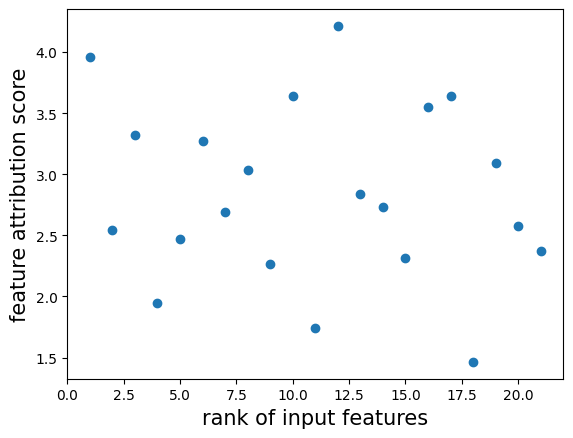

In [7]:
print(model.feature_score.cpu().detach().numpy())
import matplotlib.pyplot as plt
plt.scatter(np.arange(21)+1, model.feature_score.cpu().detach().numpy())
plt.xlabel('rank of input features', fontsize=15)
plt.ylabel('feature attribution score', fontsize=15)

In [146]:
model_output = model(dataset['train_input'])
print(model_output)

tensor([[ 0.0010],
        [-0.0018],
        [ 0.0097],
        [ 0.0005],
        [-0.0071],
        [ 0.0014],
        [-0.0167],
        [-0.0006],
        [ 0.0202],
        [ 0.0119],
        [ 0.0043],
        [ 0.0081],
        [ 0.0189],
        [ 0.0216],
        [ 0.0187],
        [ 0.0080],
        [ 0.0143],
        [-0.0025],
        [ 0.0230],
        [ 0.0166],
        [ 0.0070],
        [-0.0019],
        [ 0.0109],
        [ 0.0096],
        [ 0.0200],
        [ 0.0046],
        [ 0.0011],
        [ 0.0265],
        [ 0.0086],
        [ 0.0133],
        [ 0.0186],
        [ 0.0006],
        [ 0.0368],
        [ 0.0049],
        [-0.0046],
        [ 0.0361],
        [ 0.0106],
        [ 0.0261],
        [ 0.0047],
        [ 0.0112],
        [ 0.0319],
        [ 0.0485],
        [ 0.0159],
        [ 0.0093],
        [ 0.0257],
        [ 0.0169],
        [ 0.0148],
        [ 0.0163],
        [ 0.0413],
        [ 0.0234],
        [ 0.0097],
        [ 0.0179],
        [ 0.

In [57]:
grids = [5,10,20,50]
#grids = [5]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    #model = KAN(width=[4,2,1,1], grid=grids[i], k=3, seed=0, device=device).initialize_from_another_model(model, dataset['train_input'])
    model = model.refine(grids[i])
    results = model.fit(datasemodel = model.refine(10)
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

saving model version 0.3


| train_loss: 1.31e+10 | test_loss: 1.44e+10 | reg: 5.44e+06 | : 100%|█| 50/50 [00:01<00:00, 47.79it


saving model version 0.4
saving model version 0.5


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:01<00:00, 42.57it/s]


saving model version 0.6
saving model version 0.7


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:01<00:00, 35.41it/s]


saving model version 0.8
saving model version 0.9


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:02<00:00, 21.24it/s]


saving model version 0.10
